<a href="https://colab.research.google.com/github/semthedev/OpenCV-projects/blob/main/lab_03_MNIST_digit_recognition_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Распознавание цифры по базе MNIST / Digit Recognition using the MNIST Dataset

In this lab , I familiarize myself with the basic methods of building and training a simple neural network for recognizing handwritten digits from the MNIST dataset using the PyTorch framework. MNIST (Modified National Institute of Standards and Technology) is a classic dataset containing images of handwritten digits (0 to 9), widely used for educational and research purposes to test computer vision and deep learning techniques.


Throughout this work, I carry out the following steps:

1.   Load data *.npz file, which contains both training and test sets (images and their corresponding labels).
2.   Preprocess the loaded data by normalizing image pixels and converting numeric labels into one-hot format.
3.   Create Datasets and DataLoaders in PyTorch to efficiently handle batches during training and testing.
4.   Define a simple model using nn.Sequential, which includes several fully connected layers and a ReLU activation function.
5.   Train the model with the MSE loss function (for one-hot labels) and the Adam optimizer, then evaluate its performance on the test data.
6.   Visualize the training process by plotting the error on both the training and testing sets.
7.   Apply the trained model to a randomly selected image from the test set and compare the predicted digit with the correct label.




## Импорт необходимых библиотек

In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.keras.datasets import mnist          # MNIST: база рукописных цифр
from tensorflow.keras.models import Sequential       # Последовательная модель
from tensorflow.keras.layers import Dense            # Полносвязный слой (Dense)
from tensorflow.keras import utils                   # Утилиты для подготовки данных

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

## Загрузка данных MNIST из .npz-файла

In [50]:
path = '/content/drive/MyDrive/8 семестр весна (4 курс 2025 года)/Система компьютерного зрения /lab-03/mnist.npz'

In [52]:
# Кладём данные в словарь "data_orig" для удобства
data_orig = np.load(path, allow_pickle=True)
data_orig = {
    "train": {
        "x": data_orig["x_train"],
        "y": data_orig["y_train"],
    },
    "test": {
        "x": data_orig["x_test"],
        "y": data_orig["y_test"],
    }
}

In [54]:
# Печатаем информацию о размере тренировочных и тестовых выборок
print ("Train images", data_orig["train"]["x"].shape)
print ("Train answers", data_orig["train"]["y"].shape)
print ("Test images", data_orig["test"]["x"].shape)
print ("Test answers", data_orig["test"]["y"].shape)

Train images (60000, 28, 28)
Train answers (60000,)
Test images (10000, 28, 28)
Test answers (10000,)


In [55]:
# Печатаем структуру словаря (ключи train/test и их содержимое)
print("Ключи в файле:", data_orig)

Ключи в файле: {'train': {'x': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
     

In [56]:
# Для каждого ключа (train/test) смотрим форму массивов
for key in data_orig:
    print("Train images", data_orig["train"]["x"].shape)
    print("Train answers", data_orig["train"]["y"].shape)
    print("Test images",  data_orig["test"]["x"].shape)
    print("Test answers", data_orig["test"]["y"].shape)

Train images (60000, 28, 28)
Train answers (60000,)
Test images (10000, 28, 28)
Test answers (10000,)
Train images (60000, 28, 28)
Train answers (60000,)
Test images (10000, 28, 28)
Test answers (10000,)


Number: 4


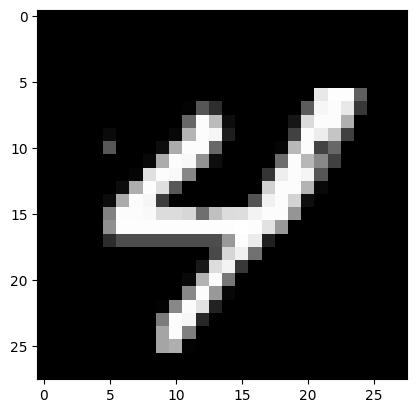

In [57]:
# Пример: смотрим одну из картинок (photo_number) и её метку
photo_number = 89
print("Number:", data_orig["train"]["y"][photo_number])
plt.imshow(data_orig["train"]["x"][photo_number], cmap="gray")
plt.show()

## Вспомогательные функции для нормализации и one-hot кодирования (PyTorch)

In [58]:
def get_vector_by_number(count):
    """
    Преобразует число в вектор длины `count` с 1.0 на позиции числа и 0.0 иначе.
    Пример:
        1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    """
    def f(number):
        res = [0.0] * count
        if (number >= 0 and number < count):
            res[number] = 1.0
        return res
    return f

In [59]:
def data_normalize_x(data_x):
    """
    Нормализация датасета по X:
    - Преобразуем numpy в torch-тензор
    - Если размерность (N, 28, 28), разворачиваем в (N, 784)
    - Делим на 255.0, приводим к float32
    """
    data_x = torch.from_numpy(data_x)
    data_x_shape_len = len(data_x.shape)

    if data_x_shape_len == 3:      # (N, 28, 28)
        data_x = data_x.reshape(data_x.shape[0], -1)
    elif data_x_shape_len == 2:    # (28, 28) или (N, ?) -- просто выравниваем
        data_x = data_x.reshape(-1)

    data_x = data_x.to(torch.float32) / 255.0
    return data_x

def data_normalize_y(data_y):
    """
    Нормализация датасета по Y:
    - Применяем функцию get_vector_by_number(10) к каждому элементу
    - Превращаем список списков в torch-тензор
    """
    data_y = list(map(get_vector_by_number(10), data_y))
    data_y = torch.tensor(data_y)
    return data_y

## Формирование датасетов и DataLoader

In [60]:
batch_size = 128

# Нормализуем данные и кладём в общий словарь "data"
data = {
    "train": {
        "x": data_normalize_x(data_orig["train"]["x"]),
        "y": data_normalize_y(data_orig["train"]["y"]),
    },
    "test": {
        "x": data_normalize_x(data_orig["test"]["x"]),
        "y": data_normalize_y(data_orig["test"]["y"]),
    }
}

# Создаём TensorDataset (x, y) для train и test
train_dataset = TensorDataset(data["train"]["x"], data["train"]["y"])
test_dataset  = TensorDataset(data["test"]["x"],  data["test"]["y"])

# Считаем, сколько всего примеров
train_count = data["train"]["x"].shape[0]
test_count  = data["test"]["x"].shape[0]

# DataLoader для обучения и теста
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False
)

## Создание модели в PyTorch (nn.Sequential, Adam, MSELoss)

In [61]:
def create_model():
    input_shape = 784   # размерность входа (28x28)
    output_shape = 10   # 10 цифр (0..9)

    model = nn.Sequential(
        nn.Linear(input_shape, 128),
        nn.ReLU(),
        nn.Linear(128, output_shape),
    )

    # Оптимизатор Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # Функция потерь MSE (для one-hot)
    loss = nn.MSELoss()

    return {
        "model": model,
        "input_shape": input_shape,
        "output_shape": output_shape,
        "optimizer": optimizer,
        "loss": loss
    }

In [62]:
# Теперь, когда nn импортирован, проблем быть не должно
model_info = create_model()
summary(model_info["model"], (model_info["input_shape"],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


## Цикл обучения (Training Loop)

In [63]:
# Выбираем устройство (GPU/CPU)
tensor_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Количество эпох
epochs = 20

# Создаём модель/оптимизатор/лосс
model_info = create_model()

model      = model_info["model"]
optimizer  = model_info["optimizer"]
loss_fn    = model_info["loss"]

# Переносим модель на устройство
model = model.to(tensor_device)

# Для записи истории ошибок (train/test)
history = {
    "loss_train": [],
    "loss_test": [],
}

for step_index in range(epochs):
    loss_train = 0
    loss_test = 0
    batch_iter = 0

    # --- Обучение на train_loader ---
    for batch_x, batch_y in train_loader:
        # Переносим батч на GPU/CPU
        batch_x = batch_x.to(tensor_device)
        batch_y = batch_y.to(tensor_device)

        # Прямой проход
        model_res = model(batch_x)

        # Считаем ошибку (MSE между предсказанием и one-hot)
        loss_value = loss_fn(model_res, batch_y)
        loss_train = loss_value.item()  # для печати

        # Обратный проход
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        # (Необязательно) чистим кэш CUDA
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Удаляем батчевые переменные, чтобы не копились
        del batch_x, batch_y

        # Просто печатаем прогресс в процентах
        batch_iter += batch_size
        batch_iter_value = round(batch_iter / train_count * 100)
        print(f"\rStep {step_index+1}, {batch_iter_value}%", end='')

    # --- Оценка на test_loader ---
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(tensor_device)
        batch_y = batch_y.to(tensor_device)

        model_res = model(batch_x)
        loss_value = loss_fn(model_res, batch_y)
        loss_test = loss_value.item()

    # Выводим данные по эпохе (loss_train и loss_test)
    print("\r", end='')  # возврат каретки
    print(f"Step {step_index+1}, loss: {loss_train},\tloss_test: {loss_test}")

    # Добавляем в историю
    history["loss_train"].append(loss_train)
    history["loss_test"].append(loss_test)

    # Останов, если ошибка стала совсем маленькой (и прошло хотя бы 5 эпох)
    if loss_test < 0.015 and step_index > 5:
        break

Step 1, loss: 0.01374361664056778,	loss_test: 0.019670657813549042
Step 2, loss: 0.011046008206903934,	loss_test: 0.015241448767483234
Step 3, loss: 0.010936027392745018,	loss_test: 0.01450028084218502
Step 4, loss: 0.007261125836521387,	loss_test: 0.013204231858253479
Step 5, loss: 0.007868155837059021,	loss_test: 0.012496165931224823
Step 6, loss: 0.01397570502012968,	loss_test: 0.010815052315592766
Step 7, loss: 0.008200520649552345,	loss_test: 0.010952373035252094


## Визуализация истории обучения

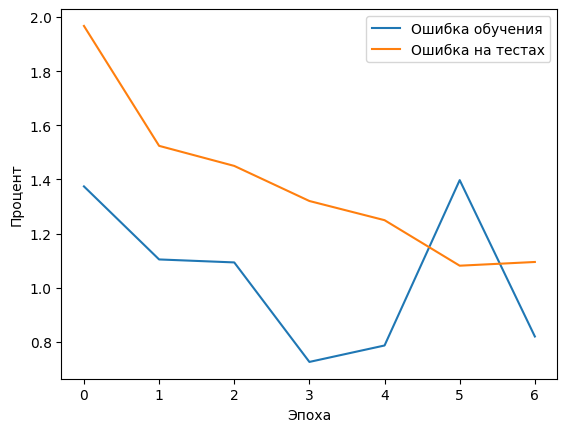

In [64]:
plt.plot(np.multiply(history['loss_train'], 100), label='Ошибка обучения')
plt.plot(np.multiply(history['loss_test'], 100),  label='Ошибка на тестах')
plt.ylabel('Процент')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

## Проверка модели на одном изображении

In [65]:
def get_answer_from_vector(vector):
    """
    Возвращает индекс максимального элемента в vector (аналог argmax).
    """
    value_max = -math.inf
    value_index = 0
    for i in range(len(vector)):
        if value_max < vector[i]:
            value_max = vector[i]
            value_index = i
    return value_index

Model answer 4
Correct answer 4


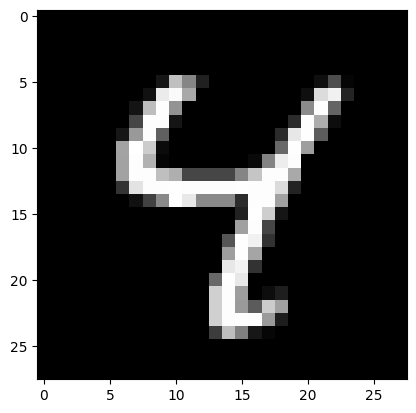

In [66]:
photo_number = 6
photo = data_orig["test"]["x"][photo_number]   # одно изображение (28×28)
correct_answer = data_orig["test"]["y"][photo_number]  # метка (0..9)

# Нормализуем вход (тот же пайплайн, что в data_normalize_x)
tensor_x = data_normalize_x(photo)
tensor_x = tensor_x[None, :]  # добавляем размерность батча (1, 784)

# Прогоняем через модель
tensor_y = model(tensor_x)

# Превращаем выход в список и берём индекс макс. значения
model_answer = get_answer_from_vector(tensor_y[0].tolist())

print("Model answer", model_answer)
print("Correct answer", correct_answer)

# Рисуем само изображение (28x28)
plt.imshow(photo, cmap='gray')
plt.show()